Utilizamos data augmentation para tener una base de datos mas grande

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import os

def augment_images_in_directory(root_directory, output_directory, target_size=(224, 224), batch_size=1, total_augmented_images=10):
    # Configuración de data augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=preprocess_input  # Asegúrate de aplicar el preprocesamiento adecuado para tu modelo
    )

    # Iterar sobre las carpetas en el directorio raíz
    for root, dirs, files in os.walk(root_directory):
        for dir_name in dirs:
            input_directory_per_class = os.path.join(root_directory, dir_name)
            output_directory_per_class = os.path.join(output_directory, dir_name)

            # Crear la carpeta de salida si no existe
            os.makedirs(output_directory_per_class, exist_ok=True)

            # Iterar sobre las imágenes en la carpeta de entrada
            for file_name in os.listdir(input_directory_per_class):
                # Comprobar si el archivo es una imagen (puedes ajustar las extensiones según tus necesidades)
                if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    input_file_path = os.path.join(input_directory_per_class, file_name)

                    # Cargar la imagen de muestra
                    image_sample = image.load_img(input_file_path, target_size=target_size)

                    # Convierte la imagen a un array numpy
                    x = image.img_to_array(image_sample)

                    # Añade una dimensión extra para que tenga la forma (1, target_size[0], target_size[1], 3)
                    x = np.expand_dims(x, axis=0)

                    # Genera imágenes aumentadas y las guarda en el directorio de destino
                    save_prefix = f"{dir_name}_{file_name.split('.')[0]}_aug"
                    save_to_dir = output_directory_per_class

                    contador = 0
                    for batch in datagen.flow(x, batch_size=batch_size, save_to_dir=save_to_dir, save_prefix=save_prefix, save_format="jpeg"):
                        contador += 1
                        if contador >= total_augmented_images:
                            break

# Directorio raíz que contiene carpetas con imágenes
root_directory = "./Images/"

# Directorio de destino para las imágenes aumentadas
output_directory = "./Images_augmentation/"

# Generar imágenes aumentadas
augment_images_in_directory(root_directory, output_directory)

Separamos el dataset en 3 conjuntos, el de entrenamiento (70%), uno de validacion (20%), y otro de test (10%)

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Ruta de la carpeta principal que contiene subcarpetas por raza
data_folder = './Images_augmentation/'

# Ruta de la carpeta de destino para los conjuntos de datos
output_folder = './Conjuntos_augmentation/'

# Porcentaje de datos para entrenamiento, validación y prueba
train_size = 0.7
val_size = 0.2
test_size = 0.1

# Crear carpetas de salida si no existen
os.makedirs(output_folder, exist_ok=True)
os.makedirs(os.path.join(output_folder, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_folder, 'val'), exist_ok=True)
os.makedirs(os.path.join(output_folder, 'test'), exist_ok=True)

# Iterar sobre las carpetas de raza
for breed_folder in os.listdir(data_folder):
    breed_path = os.path.join(data_folder, breed_folder)

    # Lista de imágenes en la carpeta de raza (con soporte para .jpg y .jpeg)
    images = [img for img in os.listdir(breed_path) if img.lower().endswith(('.jpg', '.jpeg'))]

    # Dividir la lista de imágenes en conjuntos de entrenamiento, validación y prueba
    train_images, test_images = train_test_split(images, test_size=val_size + test_size, random_state=42)
    val_images, test_images = train_test_split(test_images, test_size=test_size / (val_size + test_size), random_state=42)

    # Mover imágenes a las carpetas correspondientes
    for img in train_images:
        src = os.path.join(breed_path, img)
        dest = os.path.join(output_folder, 'train', breed_folder, img)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(src, dest)

    for img in val_images:
        src = os.path.join(breed_path, img)
        dest = os.path.join(output_folder, 'val', breed_folder, img)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(src, dest)

    for img in test_images:
        src = os.path.join(breed_path, img)
        dest = os.path.join(output_folder, 'test', breed_folder, img)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(src, dest)



In [3]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir directorios de datos
train_data_dir = './Conjuntos_augmentation/train/'  # Directorio de entrenamiento
validation_data_dir = './Conjuntos_augmentation/val'  # Directorio de validación
test_data_dir = './Conjuntos_augmentation/test/'  # Directorio de prueba
image_size = (150, 150)  # Tamaño de la imagen
batch_size = 32  # Tamaño del lote

# Carga de Dataset de entrenamiento
train_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels='inferred',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Carga de Dataset de validación
validation_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    validation_data_dir,
    labels='inferred',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Carga de Dataset de test
test_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Buffer mejora del rendimiento
train_ds = train_ds.prefetch(buffer_size=32)
validation_ds = validation_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)


Found 4169 files belonging to 10 classes.
Found 1194 files belonging to 10 classes.
Found 605 files belonging to 10 classes.


Iniciar el modelo

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling                    

model = Sequential()
#Escalado de imagenes RGB
model.add(Rescaling(scale=(1./127.5),offset=-1, input_shape=(150, 150, 3)))

#Arquitectura de la red
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu')) # Activacion de señal
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) # Activacion de señal
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # Evitar sobreajuste 


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # Evitar sobreajuste 


model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu')) # Fully Connected
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 36, 36, 64)        0

Entrenamiento del modelo

In [5]:

from tensorflow.keras.callbacks import EarlyStopping

epochs = 150

# Detiene el entrenamiento tempranamente
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True) 

# Entrena el modelo.
history = model.fit(
          train_ds,
          epochs=epochs,
          validation_data = validation_ds,
          callbacks = [es]
)

Epoch 1/150
131/131 [==============================] - 75s 558ms/step - loss: 1.9850 - accuracy: 0.2365 - val_loss: 1.8633 - val_accuracy: 0.2982
Epoch 2/150
131/131 [==============================] - 67s 508ms/step - loss: 1.7206 - accuracy: 0.3488 - val_loss: 1.6194 - val_accuracy: 0.4003
Epoch 3/150
131/131 [==============================] - 69s 528ms/step - loss: 1.5790 - accuracy: 0.4150 - val_loss: 1.5951 - val_accuracy: 0.3970
Epoch 4/150
131/131 [==============================] - 69s 525ms/step - loss: 1.4037 - accuracy: 0.4824 - val_loss: 1.3561 - val_accuracy: 0.5000
Epoch 5/150
131/131 [==============================] - 69s 526ms/step - loss: 1.3030 - accuracy: 0.5191 - val_loss: 1.2324 - val_accuracy: 0.5595
Epoch 6/150
131/131 [==============================] - 69s 525ms/step - loss: 1.1668 - accuracy: 0.5709 - val_loss: 1.2545 - val_accuracy: 0.5628
Epoch 7/150
131/131 [==============================] - 69s 526ms/step - loss: 1.0594 - accuracy: 0.6155 - val_loss: 1.1446 -

Guardar el modelo

In [6]:
model.save('./modelos/animales.h7')

INFO:tensorflow:Assets written to: ./modelos/animales.h7\assets


INFO:tensorflow:Assets written to: ./modelos/animales.h7\assets


Procesamiento de los datos

1/1 [==============================] - 0s 131ms/step
              precision    recall  f1-score   support

           0     0.8750    0.8167    0.8448       120
           1     0.9558    0.9153    0.9351       118
           2     0.7534    0.9167    0.8271       120
           3     0.7877    0.9583    0.8647       120
           4     0.9732    0.9083    0.9397       120
           5     0.9570    0.7417    0.8357       120
           6     0.9298    0.9138    0.9217       116
           7     0.9250    0.9250    0.9250       120
           8     0.8120    0.7917    0.8017       120
           9     0.9504    0.9583    0.9544       120

    accuracy                         0.8844      1194
   macro avg     0.8919    0.8846    0.8850      1194
weighted avg     0.8917    0.8844    0.8848      1194



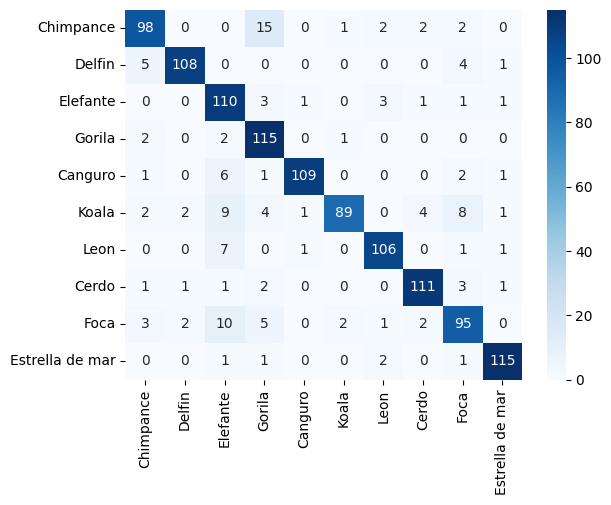

In [7]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
model = tensorflow.keras.models.load_model('./modelos/animales.h7')
results = np.concatenate([(y, model.predict(x=x)) for x, y in validation_ds], axis=1)

labels = np.argmax(results[0], axis=1)
predictions = np.argmax(results[1], axis=1)
names = np.array(["Chimpance", "Delfin", "Elefante","Gorila", "Canguro", "Koala", "Leon", "Cerdo", "Foca", "Estrella de mar"])

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=names, yticklabels=names)

#disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
#disp.plot()

print(classification_report(labels, predictions, digits = 4))

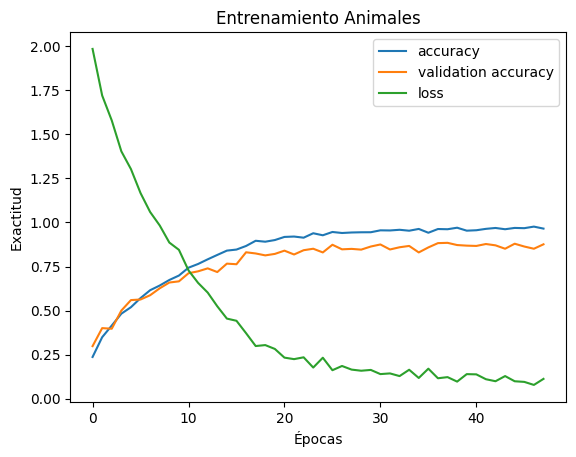

In [8]:
from matplotlib import pyplot as plt 

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.plot(history.history['loss'], label='loss')

plt.title('Entrenamiento Animales')

plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend(loc="upper right")


plt.show()

In [9]:

import numpy as np
import tensorflow.keras


etiquetas=['Chimpance', 'Delfin', 'Elefante', 'Gorila', 'Canguro', 'Koala', 'Leon', 'Cerdo', 'Foca', 'Estrella de mar']
%matplotlib inline
print("ETIQUETA PREDICHA -> ETIQUETA REAL")
for minilote in test_ds:
    prediccion_minilote = model.predict(minilote[0].numpy())
    etiqueta_real_minilote = minilote[1].numpy()
    for y_predicha, y_real in zip(np.round(prediccion_minilote,3), etiqueta_real_minilote):
        if np.argmax(y_predicha) == np.argmax(y_real):
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)])
        else:
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)], "✘")

ETIQUETA PREDICHA -> ETIQUETA REAL
1/1 [==============================] - 0s 187ms/step
Estrella de mar -> Canguro ✘
Elefante -> Leon ✘
Cerdo -> Cerdo
Cerdo -> Cerdo
Foca -> Foca
Elefante -> Leon ✘
Chimpance -> Chimpance
Gorila -> Koala ✘
Gorila -> Elefante ✘
Chimpance -> Chimpance
Foca -> Foca
Foca -> Foca
Canguro -> Canguro
Canguro -> Canguro
Cerdo -> Cerdo
Estrella de mar -> Estrella de mar
Chimpance -> Gorila ✘
Canguro -> Canguro
Delfin -> Delfin
Gorila -> Gorila
Estrella de mar -> Estrella de mar
Foca -> Foca
Canguro -> Canguro
Estrella de mar -> Estrella de mar
Koala -> Koala
Elefante -> Cerdo ✘
Chimpance -> Chimpance
Elefante -> Elefante
Foca -> Foca
Koala -> Koala
Chimpance -> Chimpance
Chimpance -> Chimpance
1/1 [==============================] - 0s 178ms/step
Estrella de mar -> Estrella de mar
Koala -> Gorila ✘
Estrella de mar -> Estrella de mar
Leon -> Leon
Cerdo -> Cerdo
Koala -> Koala
Gorila -> Gorila
Foca -> Foca
Canguro -> Canguro
Leon -> Cerdo ✘
Leon -> Leon
Foca -> Foc